## Import

In [ ]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import os
import re
import nibabel as nib

## Data Load

In [ ]:
zip_path = sorted(glob('/content/drive/Shareddrives/캡스톤 디자인1/dataset/multiclass_clahe_512/*'))

In [ ]:
import zipfile
for path in zip_path:
  zip_file = zipfile.ZipFile(path)
  zip_file.extractall('/content/datasets/'+path.split('/')[-1].split('.')[0])
  zip_file.close()

In [ ]:
PATH = '/content/datasets/'
from glob import glob
file_data = glob(PATH+'*')

In [ ]:
image_path =list()
for path in file_data:
  infile_image_path = glob(path+'/*.png')
  image_path+=infile_image_path
image_path = sorted(image_path)

In [ ]:
len(image_path)

55870

## Data Load

In [ ]:
import pandas as pd
df= pd.read_csv('/content/drive/Shareddrives/캡스톤 디자인1/processed_data_entry.csv')

In [ ]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,"Cardiomegaly,Emphysema",1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,"Cardiomegaly,Effusion",2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
76661,00030801_001.png,"Mass,Pneumonia",1,30801,38,M,PA,2048,2500,0.168,0.168
76662,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
76663,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
76664,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [ ]:
labeling_df = pd.read_csv('/content/drive/Shareddrives/캡스톤 디자인1/multi_class_path+label_nofinding_drop.csv')

In [ ]:
labeling_df

,Image Index,Finding Labels
0,/content/datasets/images_01/00000001_000.png,Cardiomegaly
1,/content/datasets/images_01/00000003_000.png,Hernia
2,/content/datasets/images_01/00000003_001.png,Hernia
3,/content/datasets/images_01/00000003_002.png,Hernia
4,/content/datasets/images_01/00000003_004.png,Hernia
...,...,...
30958,/content/datasets/images_12/00030780_000.png,Atelectasis
30959,/content/datasets/images_12/00030786_000.png,Effusion
30960,/content/datasets/images_12/00030786_006.png,Consolidation
30961,/content/datasets/images_12/00030789_000.png,Infiltration


In [ ]:
value_series=labeling_df['Finding Labels'].value_counts()
value_dict = dict()
for i in range(len(value_series)):
    index = labeling_df['Finding Labels'].value_counts().index[i].split(',')
    if len(index) < 2: # dictionary data를 만들기 위해서 일단 단일의 질병만 가지고 있는 사람들을 dicstionary형태로 만듬.
        value_dict[index[0]] =  labeling_df['Finding Labels'].value_counts()[i]
label_list=sorted(list(value_dict.keys()))

In [ ]:
label_list

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [ ]:
class2idx = {cls:idx for idx, cls in enumerate(label_list)}
class2idx

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'Nodule': 10,
 'Pleural_Thickening': 11,
 'Pneumonia': 12,
 'Pneumothorax': 13}

In [ ]:
class Train_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = np.array(Image.open(path))
        img = img/255
        img = img[:,:,np.newaxis]    
        label = class2idx[df[df['Image Index']== path.split('/')[-1]]['Finding Labels'].values[0]]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
class val_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = np.array(Image.open(path))
        img = img/255
        img = img[:,:,np.newaxis]    
        label = class2idx[df[df['Image Index']== path.split('/')[-1]]['Finding Labels'].values[0]]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
#!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 13.9 MB/s 
     |████████████████████████████████| 948 kB 60.7 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=2446c981a0aac9c8d19ed88db2336bf620201d139ac18d269c98d60ce43b127d
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import albumentations as A                                                                           
from albumentations.pytorch import ToTensorV2

In [ ]:
data_transforms = {
    'train': A.Compose(
    [
     ToTensorV2()
     ]
    ),
    'val': A.Compose(
        [
     ToTensorV2()
                            ]
                           )
}
'''
A.RandomCrop(224, 224),
     A.OneOf([
              A.HorizontalFlip(p=1),
              A.RandomRotate90(p=1),
              A.VerticalFlip(p=1)            
    ], p=1), 
'''

'\nA.RandomCrop(224, 224),\n     A.OneOf([\n              A.HorizontalFlip(p=1),\n              A.RandomRotate90(p=1),\n              A.VerticalFlip(p=1)            \n    ], p=1), \n'

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(labeling_df,test_size = 0.2,random_state = 42,stratify = labeling_df['Finding Labels'])
train_path = list(train_df['Image Index'].values)
val_path = list(val_df['Image Index'].values)

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]

# Number of classes in the dataset
num_classes = 14

# Batch size for training (change depending on how much memory you have)
batch_size = 2

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
train_data = Train_Dataset(train_path,transform = data_transforms['train'])
val_data = val_Dataset(val_path,transform =  data_transforms['val'])

In [ ]:
image_datasets = {'train' : train_data , 'val' : val_data}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
model.conv1.padding

(3, 3)

In [ ]:
num_classes = 14
num_ftrs = model.fc.in_features
model.conv1 = nn.Conv2d(1,64, kernel_size=(7,7), stride = (2,2), padding= (3,3), bias = False)
model.fc = nn.Linear(num_ftrs, num_classes)
device = torch.device('cuda:0')
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [ ]:
'''
for name, param in model.named_parameters(): 
  print(f'name:{name}') 
  print(type(param))
  print(f'param.shape:{param.shape}')
  print(f'param.requries_grad:{param.requires_grad}') 
  print('=====')
'''

"\nfor name, param in model.named_parameters(): \n  print(f'name:{name}') \n  print(type(param))\n  print(f'param.shape:{param.shape}')\n  print(f'param.requries_grad:{param.requires_grad}') \n  print('=====')\n"

In [ ]:
'''
for name, param in model.named_parameters(): 
  if name in ['conv1.weight']: 
    param.requires_grad = True 
  else: 
    param.requires_grad = False
'''

"\nfor name, param in model.named_parameters(): \n  if name in ['conv1.weight']: \n    param.requires_grad = True \n  else: \n    param.requires_grad = False\n"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 7, 7])


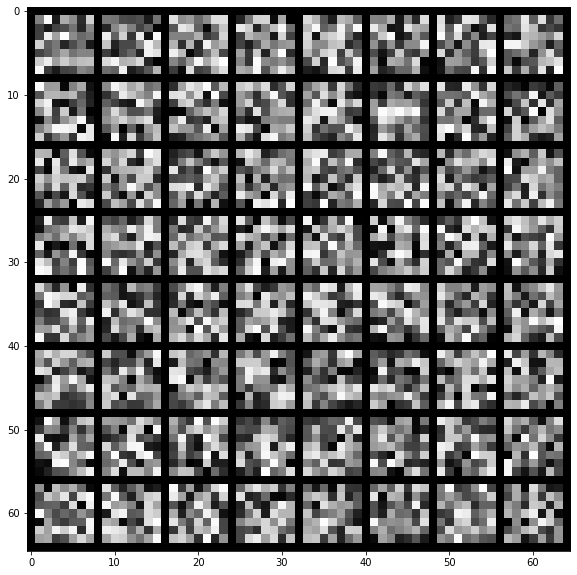

In [ ]:
#레이어 시각화

for w in model.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
plt.imshow(x_grid.permute(2,1,0))

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score , roc_curve

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    train_acc_history = []
    train_loss_hist = [] 
    train_precision = [] 
    train_recall = [] 
    train_auc = [] 
    train_f1_score =[]
    val_loss_hist = []
    val_acc_history = [] 
    val_precision = [] 
    val_recall = [] 
    val_auc = [] 
    val_f1_score = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            start = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_precision =0
            running_recall = 0
            running_f1_score =0 
            running_auc = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device = device, dtype = torch.float32)
                labels = labels.to(device = device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs = model(inputs) 
                        loss = criterion(outputs,labels)
                    # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                '''
                running_precision += precision_score(labels , outputs)
                running_recall += recall_score(labels , outputs)
                running_f1_score += f1_score(labels , outputs)
                running_auc += roc_auc_score(labels , outputs)
                '''

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            '''
            epoch_precision = running_precision/ len(dataloaders[phase].dataset)
            epoch_recall = running_recall/len(dataloaders[phase].dataset)
            epoch_f1_score = running_f1_score/len(dataloaders[phase].dataset)
            epoch_auc = running_auc/len(dataloaders[phase].dataset)
            '''
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_hist.append(epoch_loss)
              '''
              train_precision.append(epoch_precision)
              train_recall.append(epoch_recall)
              train_auc.append(epoch_auc)
              train_f1_score.append(epoch_f1_score)
              '''
            print('{} Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(phase, epoch_loss, epoch_acc,time.time()-start))
            #, P : {.4f} , R :{.4f} , AUC : {.4f}, f1 :{.4f} , , epoch_precision,epoch_recall, epoch_auc, epoch_f1_score 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_hist.append(epoch_loss)
                '''
                val_precision.append(epoch_precision)
                val_recall.append(epoch_recall)
                val_auc.append(epoch_auc)
                val_f1_score.append(epoch_f1_score)
                '''

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    train_dict = {'Loss' : train_loss_hist , 'Accuarcy' : train_acc_history}
    #, 'Precision' : train_precision, 'Recall' : train_recall, 'Auc' : train_auc , 'f1' : train_f1_score 
    val_dict = {'Loss' :val_loss_hist , 'Accuarcy' : val_acc_history}
    #, 'Precision' : val_precision , 'Recall' : val_recall, 'Auc' : val_auc , 'f1' : val_f1_score
    return model, train_dict ,val_dict

In [ ]:
summary(model.to('cuda'),(1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,136
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [ ]:
model_ft = model.to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.001)# 업데이트 할 파라미터만 넣어준다.

In [ ]:
criterion = nn.CrossEntropyLoss()


# Train and evaluate
model_ft, train_dict, val_dict  = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 2.2128 Acc: 0.3072, Time : 2470.3829
val Loss: 2.2022 Acc: 0.3084, Time : 215.4886
Epoch 1/19
----------
train Loss: 2.1966 Acc: 0.3083, Time : 2445.7766
val Loss: 2.2025 Acc: 0.3084, Time : 207.9797
Epoch 2/19
----------
train Loss: 2.1899 Acc: 0.3084, Time : 2426.3742
val Loss: 2.2265 Acc: 0.3084, Time : 208.1828
Epoch 3/19
----------
train Loss: 2.1859 Acc: 0.3083, Time : 2426.6564
val Loss: 2.1920 Acc: 0.3084, Time : 208.1394
Epoch 4/19
----------
train Loss: 2.1805 Acc: 0.3083, Time : 2426.8209
val Loss: 2.1481 Acc: 0.3076, Time : 207.7892
Epoch 5/19
----------
train Loss: 2.1604 Acc: 0.3084, Time : 2445.8855
val Loss: 2.1298 Acc: 0.3089, Time : 218.5286
Epoch 6/19
----------
train Loss: 2.1374 Acc: 0.3087, Time : 2443.5355
val Loss: 2.1331 Acc: 0.2932, Time : 213.4375
Epoch 7/19
----------
train Loss: 2.1256 Acc: 0.3100, Time : 2442.9733
val Loss: 2.1514 Acc: 0.3121, Time : 208.3593
Epoch 8/19
----------
train Loss: 2.1191 Acc: 0.3124, Time : 242

In [ ]:
torch.save(model_ft, '/content/drive/Shareddrives/캡스톤 디자인1/codes/vgg16_multiclassclassfication_model_drop_nofinding')

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Vgg16 Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,1)
plt.legend(['train','test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
train_accuracy = []
val_accuracy = []

In [ ]:
val_acc[0].to('cpu').numpy()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for i in range(len(train_acc)):
  train_accuracy.append(train_acc[i].to('cpu').numpy())
for i in range(len(val_acc)):
  val_accuracy.append(val_acc[i].to('cpu').numpy())

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Vgg16 Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim(0,1)
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
train_acc[0].to('cpu').numpy()

In [ ]:
train_accuracy

In [ ]:
model_ft = torch.load('/content/drive/Shareddrives/캡스톤 디자인1/codes/vgg16_multiclassclassfication_model_drop_nofinding')

In [ ]:
model_ft = model_ft.to(device)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.001)# 업데이트 할 파라미터만 넣어준다.
class test_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = np.array(Image.open(path))
        img = img[:,:,np.newaxis]
        img = img/255
        label =  class2idx[df[df['Image Index']== path.split('/')[-1]]['Finding Labels'].values[0]]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image.float(), label

In [ ]:
data_transforms_test = A.Compose(
        [
     ToTensorV2()
     ]
     )

In [ ]:
test_data = test_Dataset(val_path,transform = data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle= False)

In [ ]:
summary(model_ft.to('cuda'),(1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           3,136
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [ ]:
running_loss = 0.0
running_corrects = 0
start = time.time()
output_list = list()
criterion = nn.CrossEntropyLoss()

for inputs, labels in test_loader:
    inputs = inputs.to(device = device, dtype = torch.float32)
    labels = labels.to(device = device)
    # zero the parameter gradients
    optimizer_ft.zero_grad()
    outputs = model_ft(inputs)
    output_list+=list((torch.argmax(outputs,axis = 1).cpu().numpy()))
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(epoch_loss, epoch_acc, time.time()-start))

Test Loss: 2.0139 Acc: 0.3646, Time : 219.2693


In [ ]:
len(test_loader)*2

6194

In [ ]:
labels

tensor([4], device='cuda:0')

In [ ]:
torch.argmax(outputs,axis = 1).cpu().numpy()

array([8])

In [ ]:
outputs.shape

torch.Size([1, 14])

In [ ]:
dummy_df = pd.DataFrame(output_list)

In [ ]:
dummy_df.value_counts()

8     4116
4     1503
0      448
1       45
13      39
10      35
6        5
9        2
dtype: int64

In [ ]:
val_df['Finding Labels'].value_counts()

Infiltration          1910
Atelectasis            843
Effusion               791
Nodule                 541
Pneumothorax           439
Mass                   428
Consolidation          262
Pleural_Thickening     225
Cardiomegaly           219
Emphysema              178
Fibrosis               145
Edema                  126
Pneumonia               64
Hernia                  22
Name: Finding Labels, dtype: int64

In [ ]:
class2idx

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 7, 7])


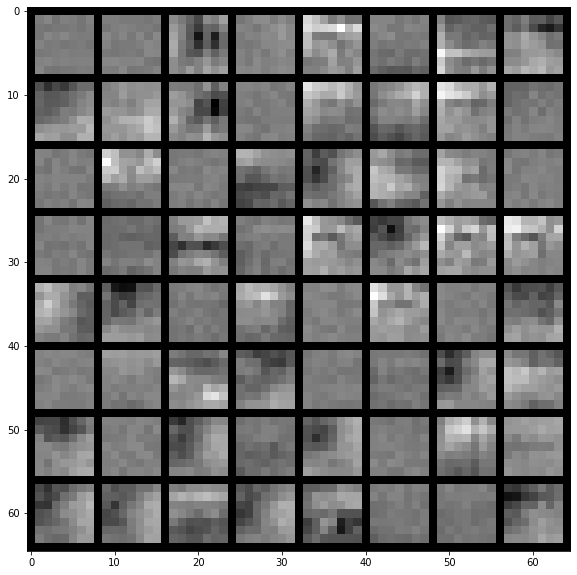

In [ ]:
#레이어 시각화

for w in model_ft.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
plt.imshow(x_grid.permute(2,1,0))